In [2]:
import os, sys

import pandas as pd
import numpy as np
import gzip
import dill
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier

root_path = root_path = os.path.realpath('../..')
data_dir = os.path.realpath(os.path.join(root_path, "auto-causality/data"))
if not os.path.isdir(data_dir):
    os.mkdir(data_dir)
print(data_dir)

C:\Users\egor.kraev\Transferwise\auto-causality\data


In [3]:
# run this cell if you are using dowhy and this repo by just pulling the source
sys.path.append(os.path.join(root_path, "dowhy"))
sys.path.append(os.path.join(root_path, "auto-causality"))

In [4]:
from dowhy import CausalModel

from auto_causality.utils import featurize, AutoMLWrapper
from auto_causality.params import SimpleParamService
from auto_causality.scoring import make_scores

In [5]:
# load raw data
data= pd.read_csv("https://raw.githubusercontent.com/AMLab-Amsterdam/CEVAE/master/datasets/IHDP/csv/ihdp_npci_1.csv", header = None)
col =  ["treatment", "y_factual", "y_cfactual", "mu0", "mu1" ,]
for i in range(1,26):
    col.append("x"+str(i))
data.columns = col

display(data.dtypes)
data.head()

treatment       int64
y_factual     float64
y_cfactual    float64
mu0           float64
mu1           float64
x1            float64
x2            float64
x3            float64
x4            float64
x5            float64
x6            float64
x7              int64
x8              int64
x9              int64
x10             int64
x11             int64
x12             int64
x13             int64
x14             int64
x15             int64
x16             int64
x17             int64
x18             int64
x19             int64
x20             int64
x21             int64
x22             int64
x23             int64
x24             int64
x25             int64
dtype: object

,treatment,y_factual,y_cfactual,mu0,mu1,x1,x2,x3,x4,x5,...,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25
0,1,5.599916,4.318780,3.268256,6.854457,-0.528603,-0.343455,1.128554,0.161703,-0.316603,...,1,1,1,1,0,0,0,0,0,0
1,0,6.875856,7.856495,6.636059,7.562718,-1.736945,-1.802002,0.383828,2.244320,-0.629189,...,1,1,1,1,0,0,0,0,0,0
2,0,2.996273,6.633952,1.570536,6.121617,-0.807451,-0.202946,-0.360898,-0.879606,0.808706,...,1,0,1,1,0,0,0,0,0,0
3,0,1.366206,5.697239,1.244738,5.889125,0.390083,0.596582,-1.850350,-0.879606,-0.004017,...,1,0,1,1,0,0,0,0,0,0
4,0,1.963538,6.202582,1.685048,6.191994,-1.045229,-0.602710,0.011465,0.161703,0.683672,...,1,1,1,1,0,0,0,0,0,0


In [6]:
# drop the columns we don't care about
ignore_patterns = ['y_cfactual','mu']
ignore_cols = [c for c in data.columns if any([s in c for s in ignore_patterns])]
data = data.drop(columns=ignore_cols)

In [7]:
# set all the control parameters here
train_size = 0.5
test_size = None
time_budget = 60
num_cores = os.cpu_count() - 1
conf_intervals = False

In [8]:
# prepare the data

treatment = "treatment"
targets = ["y_factual"] # it's good to allow multiple ones
features = [c for c in data.columns if c not in [treatment] + targets]

data[treatment] = data[treatment].astype(int)
# this is a trick to bypass some DoWhy/EconML bugs
data["random"] = np.random.randint(0, 2, size=len(data))

used_df = featurize(
        data,
        features=features,
        exclude_cols=[treatment] + targets,
        drop_first=False,
    )
used_features = [
        c for c in used_df.columns if c not in ignore_cols + [treatment] + targets
    ]


# Let's treat all features as effect modifiers
features_X = [f for f in used_features if f != "random"]
features_W = [f for f in used_features if f not in features_X]

In [ ]:
train_df, test_df = train_test_split(used_df, train_size=train_size)
if test_size is not None:
    test_df = test_df.sample(test_size)

test_df.to_csv(os.path.join(data_dir, f"test_{time_budget}.csv"))
train_df.to_csv(os.path.join(data_dir, f"train_{time_budget}.csv"))

In [9]:
# define model parametrization
propensity_model = DummyClassifier(strategy="prior")
outcome_model = AutoMLWrapper(
    fit_params={
        "time_budget": time_budget,
        "verbose": 1,
        "task": "regression",
        "n_jobs": num_cores,
        "pred_time_limit": 10 / 1e6,
    }
)

cfg = SimpleParamService(
    propensity_model,
    outcome_model,
    conf_intervals=conf_intervals,
    n_bootstrap_samples=20,
    n_estimators=500,
    max_depth=10,
    min_leaf_size=2*len(used_features)
)

In [9]:
# and now let's fit some models!

for outcome in targets:  
    print(outcome)
    model = CausalModel(
        data=train_df,
        treatment=treatment,
        outcome=outcome,
        common_causes=features_W,
        effect_modifiers=features_X,
    )
    identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
    
    estimates = {}
    eis ={}
    for estimator in cfg.estimators():
        if not any(
            [
                e in estimator
                for e in [
                    "causality",
                    "metalearners",
                    "CausalForestDML",
                    "LinearDML",
                    "SparseLinearDML"
                    "ForestDRLearner",
                    "LinearDRLearner",
                    "Ortho"
                ]
            ]
        ):  
            continue

        method_params = cfg.method_params(estimator)
        print("fitting", estimator, method_params)

        estimates[estimator] = model.estimate_effect(
            identified_estimand,
            method_name=estimator,
            control_value=0,
            treatment_value=1,
            target_units="ate",  # condition used for CATE
            confidence_intervals=conf_intervals,
            method_params=method_params,
        )

        estimates[estimator].interpret()

        if conf_intervals:
            X_train = train_df[estimates[estimator].estimator._effect_modifier_names]
            est_obj = estimates[estimator].estimator.estimator
            eis[estimator] = est_obj.effect_inference(X_train)
            print(eis[estimator].population_summary())
        else:
            eis[estimator] = None

        try:
            te_train = estimates[estimator].cate_estimates
            X_test = test_df[estimates[estimator].estimator._effect_modifier_names] 
            te_test = estimates[estimator].estimator.estimator.effect(X_test).flatten()
            print(
                "manual mean impact:",
                te_train.mean(),
                te_test.mean(),
                "std:",
                te_train.std(),
            )
        except:
            te_train = estimates[estimator].estimator.effect(train_df)
            te_test = estimates[estimator].estimator.effect(test_df)

        scores = {
            "estimator": estimator,
            "outcome": outcome,
            "train": make_scores(model, train_df, te_train),
            "test": make_scores(model, test_df, te_test),
        }

        print(
            f"Scores for {estimator}_{outcome}",
            scores["train"]["erupt"],
            scores["test"]["erupt"],
        )

        print("dumping...")
        fname = os.path.join(
            data_dir, f"scores_{estimator}_{outcome}_{time_budget}.zip"
        )
        with gzip.open(fname, "wb") as f:
            dill.dump(scores, f)
        fname = os.path.join(
            data_dir, f"model_{estimator}_{outcome}_{time_budget}.zip"
        )
        with gzip.open(fname, "wb") as f:
            dill.dump(estimates[estimator], f)

        print("yahoo!")

y_factual
fitting backdoor.econml.orf.DROrthoForest {'init_params': {'propensity_model': DummyClassifier(), 'model_Y': Ridge(alpha=0.01), 'n_jobs': None, 'max_depth': 10, 'n_trees': 500, 'min_leaf_size': 52, 'backend': 'threading'}, 'fit_params': {}}


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 373 out of 373 | elapsed:    4.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concur

Increasing the treatment variable(s) [treatment] from [0] to [1] causes an increase of 3.848690359468098 in the expected value of the outcome [y_factual], over the data distribution/population represented by the dataset.


[Parallel(n_jobs=1)]: Done 374 out of 374 | elapsed:    5.5s finished


manual mean impact: 3.848690359468098 3.9524937605756847 std: 1.1927819517356248
Scores for backdoor.econml.orf.DROrthoForest_y_factual 6.427314264569056 6.445663412910029
dumping...
yahoo!
fitting backdoor.econml.orf.DMLOrthoForest {'init_params': {'model_T': DummyClassifier(), 'model_Y': Ridge(alpha=0.01), 'discrete_treatment': True, 'n_jobs': None, 'max_depth': 10, 'n_trees': 500, 'min_leaf_size': 52, 'backend': 'threading'}, 'fit_params': {}}


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 373 out of 373 | elapsed:    4.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concur

Increasing the treatment variable(s) [treatment] from [0] to [1] causes an increase of 3.395061735460179 in the expected value of the outcome [y_factual], over the data distribution/population represented by the dataset.


[Parallel(n_jobs=1)]: Done 374 out of 374 | elapsed:    4.0s finished


manual mean impact: 3.395061735460179 3.533415345365768 std: 1.1107348908840942
Scores for backdoor.econml.orf.DMLOrthoForest_y_factual 6.411460340797122 6.465227217203946
dumping...
yahoo!


In [10]:
import glob
from collections import defaultdict

scores = defaultdict(lambda:defaultdict(dict))
for outcome in targets:
    print(outcome)
    for estimator in cfg.estimators():
        try:
            fname = os.path.join(data_dir, f"scores_{estimator}_*_{time_budget}.zip")
            files = glob.glob(fname)
            if not len(files):
                continue
            with gzip.open(files[0], "rb") as f:
                scores[outcome][estimator] = dill.load(f)
                print(estimator, "score:", scores[outcome][estimator])
        except Exception as e:
            display(e)
            continue

y_factual
backdoor.econml.metalearners.SLearner score: {'estimator': 'backdoor.econml.metalearners.SLearner', 'outcome': 'y_factual', 'train': {'erupt': 6.414997945066353, 'ate': 3.8596471708575883, 'intrp': <econml.cate_interpreter._interpreters.SingleTreeCateInterpreter object at 0x000001763C6514C0>}, 'test': {'erupt': 6.446041000195049, 'ate': 3.8102324628479027, 'intrp': <econml.cate_interpreter._interpreters.SingleTreeCateInterpreter object at 0x000001763C6331F0>}}
backdoor.econml.metalearners.TLearner score: {'estimator': 'backdoor.econml.metalearners.TLearner', 'outcome': 'y_factual', 'train': {'erupt': 6.432546868995543, 'ate': 3.9703885621388033, 'intrp': <econml.cate_interpreter._interpreters.SingleTreeCateInterpreter object at 0x000001763C5C7130>}, 'test': {'erupt': 6.446041000195049, 'ate': 3.9249518805425234, 'intrp': <econml.cate_interpreter._interpreters.SingleTreeCateInterpreter object at 0x000001763C633190>}}
backdoor.econml.metalearners.XLearner score: {'estimator': '

In [11]:
# add a baseline calculation
train_df = pd.read_csv(os.path.join(data_dir, f"train_{time_budget}.csv"))
test_df = pd.read_csv(os.path.join(data_dir, f"test_{time_budget}.csv"))
# purge previous ones
for outcome in targets:
    def ate(df: pd.DataFrame):
        return df[outcome][df[treatment]==1].mean() - df[outcome][df[treatment]==0].mean()

    scores[outcome]["baseline"]={"estimator": "baseline",
                               "outcome": outcome,
                              "train":{"erupt": train_df[outcome].mean(),"ate": ate(train_df)},
                              "test":{"erupt": test_df[outcome].mean(),"ate": ate(test_df)}}
                              
                              


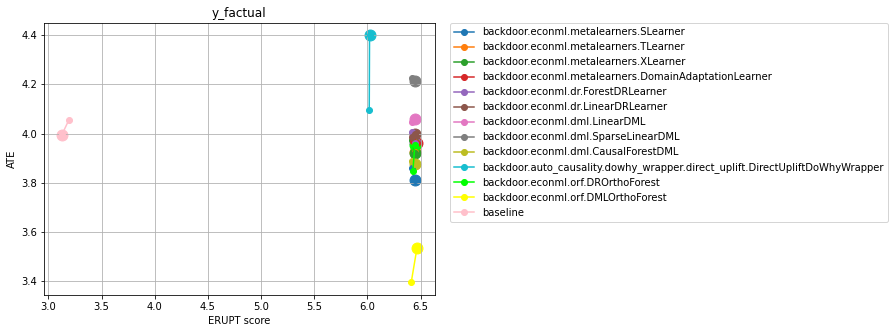

In [14]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

colors = list(matplotlib.colors.TABLEAU_COLORS) + [
    matplotlib.colors.CSS4_COLORS['lime'],
    matplotlib.colors.CSS4_COLORS['yellow'],
    matplotlib.colors.CSS4_COLORS['pink']
]

for outcome, v in scores.items():
    plt.figure(figsize = (7,5))
    plt.title(outcome)
    for (est, scr),col in zip(v.items(),colors):
        sc = [scr['train']['erupt'], scr['test']['erupt']]
        crv = [scr['train']['ate'], scr['test']['ate']]
        plt.plot(sc, crv, color=col, marker="o")
        plt.scatter(sc[1:],crv[1:], c=col, s=120 )
        plt.grid()
        plt.xlabel("ERUPT score")
        plt.ylabel("ATE")
        plt.legend(v.keys(),bbox_to_anchor=(1.04,1), borderaxespad=0)
        
    
    plt.show()



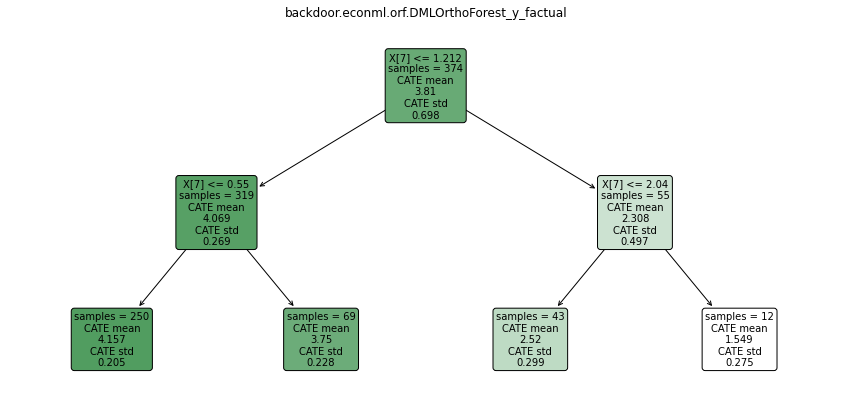

In [27]:
for outcome, v in scores.items():
    for est, scr in v.items():
        intrp = scr['test']['intrp']
        plt.figure(figsize=(15, 7))
        intrp.plot(feature_names=intrp.feature_names, fontsize=10)
#         intrp.plot( fontsize=10)
        plt.title(f"{estimator}_{outcome}")
        plt.show()
        break

In [ ]:
# TODO: add SHAP plots!